### Import Library

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image


In [59]:
# Menghubungkan google colab dengan goggle drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Data augmentasi dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split untuk validasi
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Computer Vision - Cat vs Rabbit-20241216T015625Z-001/Computer Vision - Cat vs Rabbit/archive (28)/train-cat-rabbit',
    target_size=(224, 224),  # Resolusi gambar
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Computer Vision - Cat vs Rabbit-20241216T015625Z-001/Computer Vision - Cat vs Rabbit/archive (28)/val-cat-rabbit',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 861 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


### Model CNN

In [61]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Changed to 1 unit with sigmoid activation
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
# Training Model 1
history_cnn = model_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 524ms/step - accuracy: 0.6919 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 437ms/step - accuracy: 0.7523 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.7214 - loss: 0.6806 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.7381 - loss: 0.6742 - val_accuracy: 0.5000 - val_loss: 0.6944


In [63]:
# Evaluasi Model 1
print("Evaluasi Model CNN")
cnn_loss, cnn_acc = model_cnn.evaluate(validation_generator)


Evaluasi Model CNN
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 0.4648 - loss: 0.6980


### Model Transfer Learning ResNet50

In [66]:
base_model_VGG16 = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224,224,3))

last = base_model_VGG16.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(1, activation='sigmoid')(x)
model_VGG16 = Model(inputs=base_model_VGG16.input, outputs=x)

model_VGG16.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [67]:
# Training Model 2
history_resnet = model_VGG16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6624 - loss: 0.6067 - val_accuracy: 0.5000 - val_loss: 0.9459
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 688ms/step - accuracy: 0.7363 - loss: 0.4645 - val_accuracy: 0.6829 - val_loss: 0.5477
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 673ms/step - accuracy: 0.8167 - loss: 0.3571 - val_accuracy: 0.5122 - val_loss: 0.9914
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 678ms/step - accuracy: 0.8301 - loss: 0.3728 - val_accuracy: 0.8171 - val_loss: 0.4180
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step - accuracy: 0.8978 - loss: 0.2514 - val_accuracy: 0.7561 - val_loss: 0.5383
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 683ms/step - accuracy: 0.8284 - loss: 0.3605 - val_accuracy: 0.8171 - val_loss: 0.6287
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 656ms/step - accuracy: 0.9305 - loss: 0.1835 - val_accuracy: 0.8293 - val_loss: 0.8186


In [68]:
# Evaluasi Model 2
print("Evaluasi Model ResNet50")
resnet_loss, resnet_acc = model_VGG16.evaluate(validation_generator)

Evaluasi Model ResNet50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - accuracy: 0.5156 - loss: 0.8389


### Model Transfer Learning MobileNetV2

In [69]:
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = False
model_mobilenet = Sequential([
    base_model_mobilenet,
    Flatten(),
    Dense(118, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Changed to 1 unit with sigmoid activation for binary classification
])

model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
# Training Model 3
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 721ms/step - accuracy: 0.6934 - loss: 2.6796 - val_accuracy: 0.5000 - val_loss: 4.4018
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.7530 - loss: 1.9649 - val_accuracy: 0.5000 - val_loss: 2.8532
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.7681 - loss: 1.1030 - val_accuracy: 0.5000 - val_loss: 1.2660
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - accuracy: 0.7758 - loss: 0.4639 - val_accuracy: 0.8171 - val_loss: 0.4388
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - accuracy: 0.9375 - loss: 0.2142 - val_accuracy: 0.9512 - val_loss: 0.2200
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 427ms/step - accuracy: 0.9824 - loss: 0.1435 - val_accuracy: 0.9512 - val_loss: 0.2229
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step - accuracy: 0.9729 - loss: 0.1418 - val_accuracy: 0.9512 - val_loss: 0.1786
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 383ms/step - accuracy: 0.9769 - loss: 0.1441 - val_accu

In [71]:
# Evaluasi Model 3
print("Evaluasi Model MobileNetV2")
mobilenet_loss, mobilenet_acc = model_mobilenet.evaluate(validation_generator)

Evaluasi Model MobileNetV2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.9800 - loss: 0.0963


### Perbandingan Model

In [72]:
print("\n\nRingkasan Hasil Evaluasi:")
print(f"CNN: Loss={cnn_loss}, Accuracy={cnn_acc}")
print(f"ResNet50: Loss={resnet_loss}, Accuracy={resnet_acc}")
print(f"MobileNetV2: Loss={mobilenet_loss}, Accuracy={mobilenet_acc}")




Ringkasan Hasil Evaluasi:
CNN: Loss=0.6944438219070435, Accuracy=0.5
ResNet50: Loss=0.8631003499031067, Accuracy=0.5
MobileNetV2: Loss=0.11016055941581726, Accuracy=0.9756097793579102


### Learning Curves

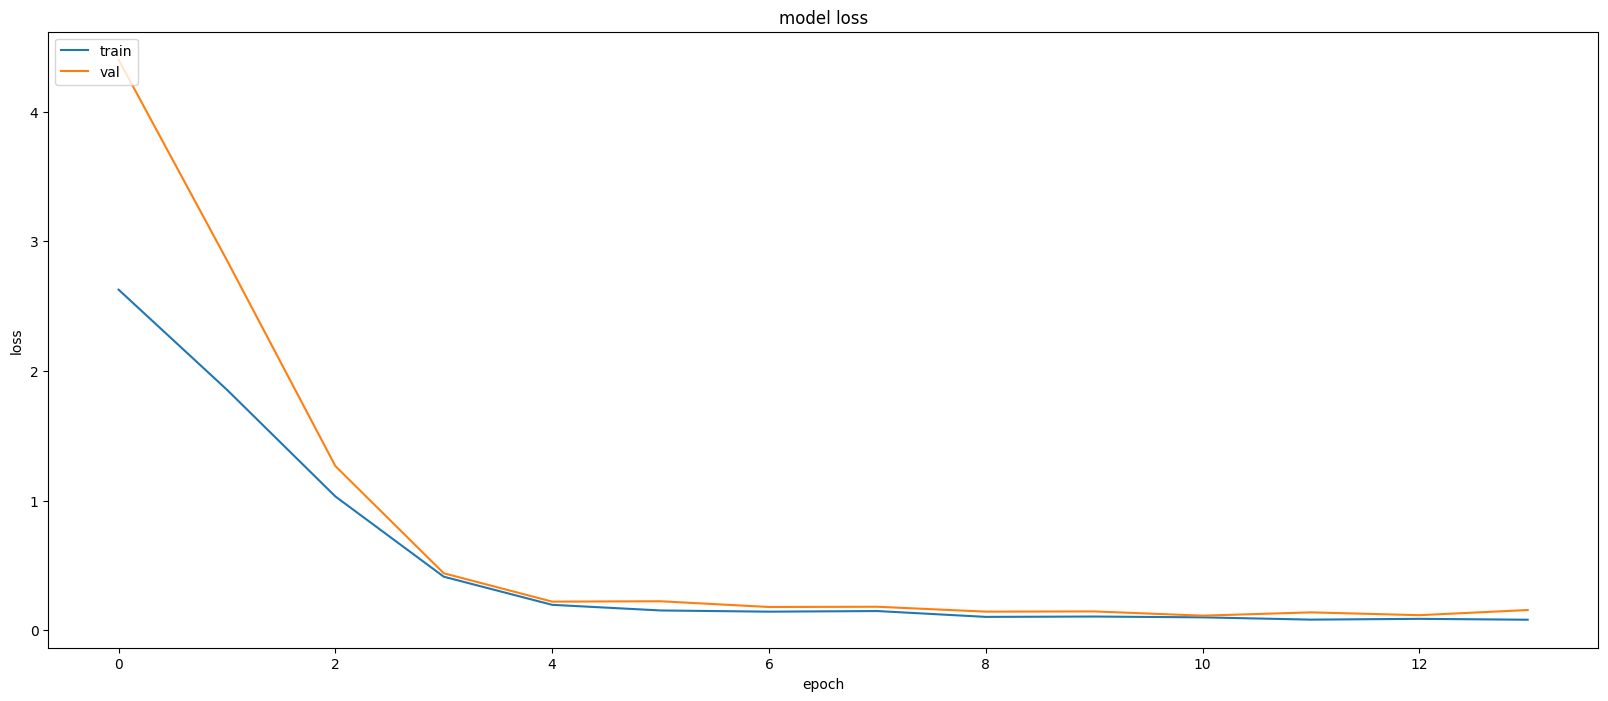

In [73]:
plt.figure(figsize=(20,8))
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

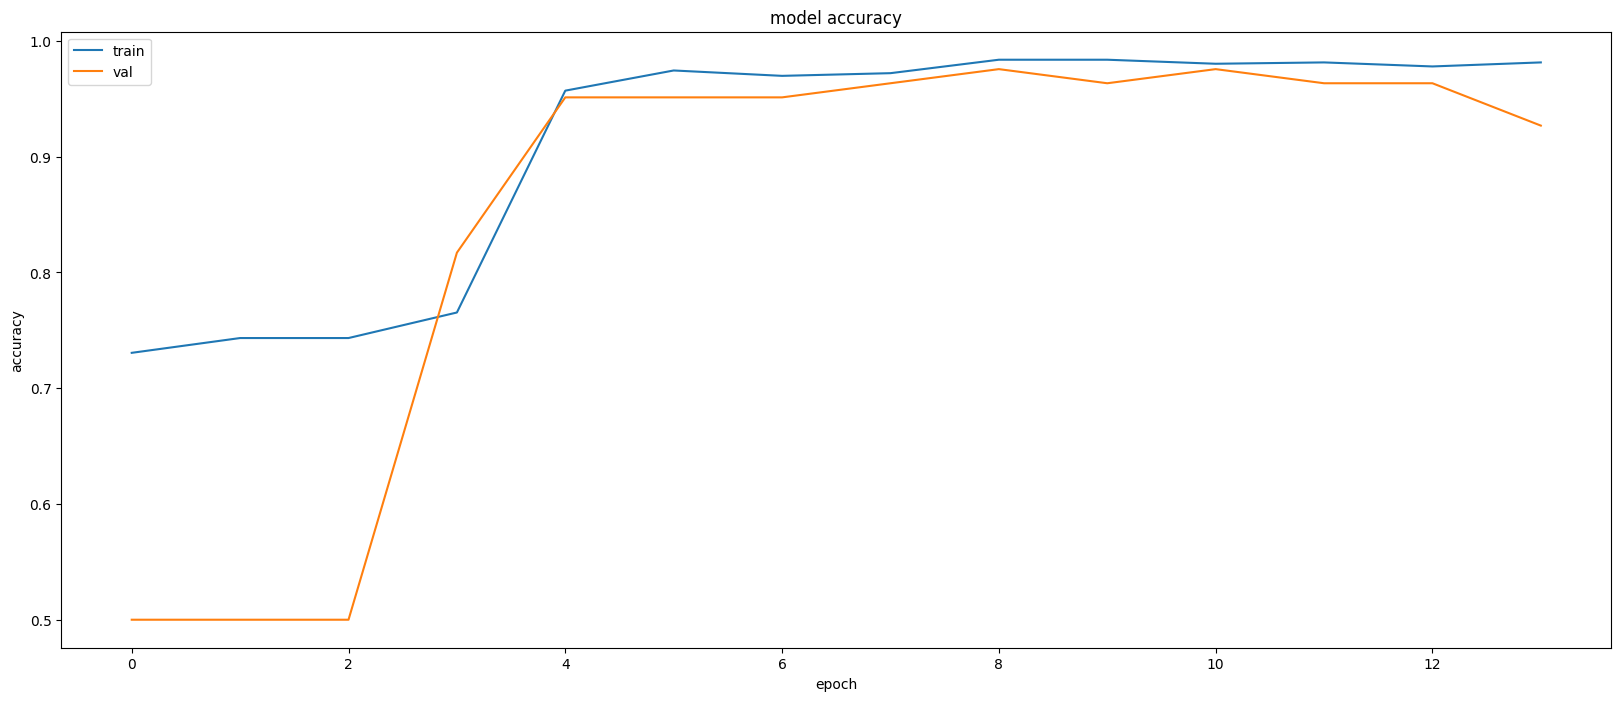

In [74]:
plt.figure(figsize=(20,8))
plt.plot(history_mobilenet.history['accuracy'])
plt.plot(history_mobilenet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Pemilihan Model Terbaik

In [75]:
best_model = None
if cnn_acc >= resnet_acc and cnn_acc >= mobilenet_acc:
    best_model = model_cnn
    print("Model terbaik: CNN")
elif resnet_acc >= cnn_acc and resnet_acc >= mobilenet_acc:
    best_model = model_VGG16
    print("Model terbaik: ResNet50")
else:
    best_model = model_mobilenet
    print("Model terbaik: MobileNetV2")

Model terbaik: MobileNetV2


# Test Input Gambar

In [105]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224)) # Using image from keras.preprocessing
    img_array = image.img_to_array(img) / 255.0          # Using image from keras.preprocessing
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)
    class_label = list(train_generator.class_indices.keys())[class_idx]
    return class_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


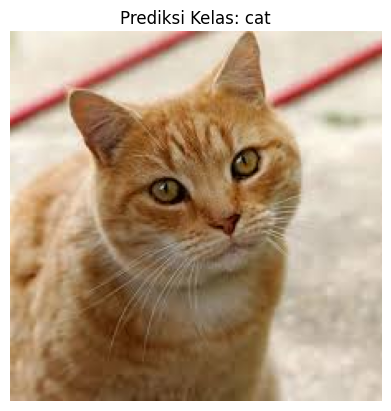

In [106]:
uploaded_image_path = '/content/drive/MyDrive/Computer Vision - Cat vs Rabbit-20241216T015625Z-001/download (3).jpg'
predicted_class = predict_image(uploaded_image_path, best_model)
image = Image.open(uploaded_image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediksi Kelas: {predicted_class}")
plt.show()


Thank You